<a href="https://colab.research.google.com/github/Y07-assine/Convolutional-Neural-Networks-on-signs-dataset/blob/main/CNN_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Networks on signs dataset

Import the needed packages

In [14]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

Import the 'Signs' dataset

In [15]:
def load_dataset():
    train_dataset = h5py.File('/content/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

load the dataset

In [16]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

**The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.**

let's show an example of a labelled image in the dataset

y = 2


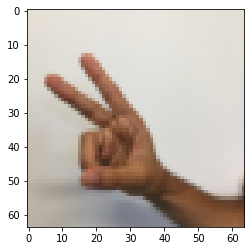

In [17]:
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

Examine the shapes of our data

In [18]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = np.eye(6)[Y_train_orig.reshape(-1)]
Y_test = np.eye(6)[Y_test_orig.reshape(-1)]
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]


In [19]:
def initialize_parameters():
    W1 = tf.Variable(tf.random.truncated_normal([4, 4, 3, 8], stddev=0.1, seed=0))
    W2 = tf.Variable(tf.random.truncated_normal([2, 2, 8, 16], stddev=0.1, seed=1))
    W3 = tf.Variable(tf.random.truncated_normal([2*2*16, 6], stddev=0.1, seed=2))

    parameters = [W1,
                   W2,
                  W3]
    
    return parameters

In [20]:
parameters = initialize_parameters()
print("W1[1,1,1] = \n" + str(parameters[0][1,1,1]))
print("W1.shape: " + str(parameters[0].shape))
print("\n")
print("W2[1,1,1] = \n" + str(parameters[1][1,1,1]))
print("W2.shape: " + str(parameters[1].shape))

W1[1,1,1] = 
tf.Tensor(
[ 0.1447671  -0.05414319  0.13151479  0.13970079  0.05702114  0.06457475
  0.01114161  0.00709099], shape=(8,), dtype=float32)
W1.shape: (4, 4, 3, 8)


W2[1,1,1] = 
tf.Tensor(
[-0.12470769  0.19388527  0.01390898  0.01152461 -0.0065414   0.04360773
  0.0847746   0.05029554  0.04475504 -0.0030829  -0.06812374  0.10264163
  0.19581345  0.02180766 -0.16781066  0.04616431], shape=(16,), dtype=float32)
W2.shape: (2, 2, 8, 16)


Implement the forward_propagation function below to build the following model: CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED. You should use the functions above.

In detail, we will use the following parameters for all the steps:

- Conv2D: stride 1, padding is "SAME"
- ReLU
- Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
- Conv2D: stride 1, padding is "SAME"
- ReLU
- Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
- Flatten the previous output.
- FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost.

In [21]:
def forward_propagation(X, parameters):

  W1 = parameters[0]
  W2 = parameters[1]
  W3 = parameters[2]

  
  #convolutional layer 1
  Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
  #Apply the ReLU activation Function
  A1 = tf.nn.relu(Z1)                                                         
  #Apply the max pooling  
  P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')  

  #convolutional layer 2
  Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
  #Apply the ReLU activation Function
  A2 = tf.nn.relu(Z2)                                                         
  #Apply the max pooling  
  P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')  
  #Fully Connected Layer
  #Flattening Second Layer
  F1 = tf.reshape(P2,[-1,2*2*16])
  Z3 = tf.matmul(F1,W3)

  return Z3



Compute cost

- tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y): computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss.
- tf.reduce_mean: computes the mean of elements across dimensions of a tensor. Use this to calculate the sum of the losses over all the examples to get the overall cost.

In [22]:
def compute_cost(Z3, Y):
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
  return cost

Model 

In [23]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [24]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,num_epochs = 100, minibatch_size = 64, print_cost = True):
  costs=[]
  accuracies = []
  seed = 3 
  (m, n_H0, n_W0, n_C0) = X_train.shape
  parameters = initialize_parameters()
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  for epoch in range(num_epochs):
    minibatch_cost = 0.
    num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
    seed = seed + 1
    minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

    for minibatch in minibatches:
      # Select a minibatch
      (minibatch_X, minibatch_Y) = minibatch
      with tf.GradientTape() as tape:
        Z3 = forward_propagation(minibatch_X,parameters)
        current_loss = compute_cost(Z3,minibatch_Y)
        grads = tape.gradient( current_loss , parameters )
        optimizer.apply_gradients(zip(grads,parameters))
        temp_cost = current_loss.numpy()
      
      minibatch_cost += temp_cost / num_minibatches

    # Print the cost every epoch
    if print_cost == True and epoch % 5 == 0:
        print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
    if print_cost == True and epoch % 1 == 0:
        costs.append(minibatch_cost)
  # plot the cost
  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations (per tens)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

  Z3 = forward_propagation(X_train,parameters)
  current_loss = compute_cost(Z3,Y_train)
  costs.append(current_loss)
  pred = tf.nn.softmax(Z3)
  correct_prediction = tf.equal(tf.argmax(pred,axis=1),tf.argmax(Y_train, axis=1))
  train_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
  Z3 = forward_propagation(X_test,parameters)
  current_loss = compute_cost(Z3,Y_test)
  costs.append(current_loss)
  pred = tf.nn.softmax(Z3)
  correct_prediction = tf.equal(tf.argmax(pred,axis=1),tf.argmax(Y_test, axis=1))
  test_accuracy =  tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
  print("Train Accuracy:", train_accuracy)
  print("Test Accuracy:", test_accuracy)


Cost after epoch 0: 1.907949
Cost after epoch 5: 1.439812
Cost after epoch 10: 0.843526
Cost after epoch 15: 0.672881
Cost after epoch 20: 0.588231
Cost after epoch 25: 0.519037
Cost after epoch 30: 0.493517
Cost after epoch 35: 0.500477
Cost after epoch 40: 0.495355
Cost after epoch 45: 0.419690
Cost after epoch 50: 0.454369
Cost after epoch 55: 0.410460
Cost after epoch 60: 0.390031
Cost after epoch 65: 0.354557
Cost after epoch 70: 0.401280
Cost after epoch 75: 0.401325
Cost after epoch 80: 0.366241
Cost after epoch 85: 0.335300
Cost after epoch 90: 0.353795
Cost after epoch 95: 0.357116


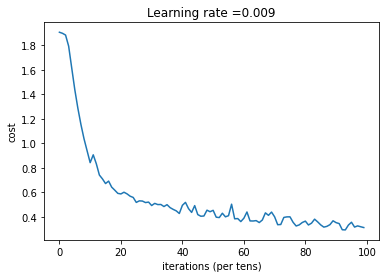

Train Accuracy: 0.90833336
Test Accuracy: 0.85


In [28]:
model(X_train, Y_train, X_test, Y_test)

**85% accuracy on test set** 